<a href="https://colab.research.google.com/github/spratik/sam_onnx_full_export/blob/main/sam_onnx_export_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install onnx
!pip install torch

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-zzk4u150
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-zzk4u150
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=82d372123d090371acf130623a49e7d7ee650179decf35cd1d393204469f7f94
  Stored in directory: /tmp/pip-ephem-wheel-cache-1wsxqtmd/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 41.5 MB/s eta 0:00:00


In [2]:
from segment_anything import sam_model_registry
from segment_anything.utils.onnx import SamOnnxModel
import torch

In [3]:
# Download SAM model checkpoint
!pip install wget
!python -m wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=b1146c74a453313e1d4f23d660799fc763628b5719a8c66f7a493f0db545990e
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget

Saved under sam_vit_b_01ec64.pth


In [4]:
# Load SAM model
sam = sam_model_registry["vit_b"](checkpoint="./sam_vit_b_01ec64.pth")

In [5]:
# Export images encoder from SAM model to ONNX
torch.onnx.export(
    f="vit_b_encoder.onnx",
    model=sam.image_encoder,
    args=torch.randn(1, 3, 1024, 1024),
    input_names=["images"],
    output_names=["embeddings"],
    export_params=True
)

/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/image_encoder.py:258: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if pad_h > 0 or pad_w > 0:
/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/image_encoder.py:304: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  max_rel_dist = int(2 * max(q_size, k_size) - 1)
/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/image_encoder.py:304: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of 

In [6]:
# Export mask decoder from SAM model to ONNX
onnx_model = SamOnnxModel(sam, return_single_mask=True)
embed_dim = sam.prompt_encoder.embed_dim
embed_size = sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
    "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
    "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
    "has_mask_input": torch.tensor([1], dtype=torch.float),
    "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
}
output_names = ["masks", "iou_predictions", "low_res_masks"]
torch.onnx.export(
    f="vit_b_decoder.onnx",
    model=onnx_model,
    args=tuple(dummy_inputs.values()),
    input_names=list(dummy_inputs.keys()),
    output_names=output_names,
    dynamic_axes={
        "point_coords": {1: "num_points"},
        "point_labels": {1: "num_points"}
    },
    export_params=True,
    opset_version=17,
    do_constant_folding=True
)

/usr/local/lib/python3.10/dist-packages/segment_anything/modeling/transformer.py:232: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  attn = attn / math.sqrt(c_per_head)
/usr/local/lib/python3.10/dist-packages/segment_anything/utils/onnx.py:97: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  score_reweight = torch.tensor(
/usr/local/lib/python3.10/dist-packages/torch/onnx/symbolic_opset9.py:5856: UserWarning: Exporting aten::index operator of advanced indexing in opset 17 is achieved by combination of multiple ONNX opera

In [7]:
!ls

sample_data  sam_vit_b_01ec64.pth  vit_b_decoder.onnx  vit_b_encoder.onnx


In [8]:
!pip install onnxruntime
!pip install Pillow
!pip install numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.9 MB/s eta 0:00:00


In [9]:
import onnxruntime as ort
import numpy as np
from PIL import Image
from copy import deepcopy

In [10]:
# LOAD IMAGE
img = Image.open("cat_dog.jpg").convert("RGB")
img.size

(612, 415)

In [11]:
orig_width, orig_height = img.size
resized_width, resized_height = img.size

if orig_width > orig_height:
    resized_width = 1024
    resized_height = int(1024 / orig_width * orig_height)
else:
    resized_height = 1024
    resized_width = int(1024 / orig_height * orig_width)

img = img.resize((resized_width, resized_height), Image.Resampling.BILINEAR)

img.size

(1024, 694)

In [13]:
# Make image square 1024x1024 by padding short side by zeros
if resized_height < resized_width:
    input_tensor = np.pad(input_tensor,((0,0),(0,0),(0,1024-resized_height),(0,0)))
else:
    input_tensor = np.pad(input_tensor,((0,0),(0,0),(0,0),(0,1024-resized_width)))

input_tensor.shape

(1, 3, 1024, 1024)

In [14]:
# 2. GET IMAGE EMBEDDINGS USING IMAGE ENCODER
encoder = ort.InferenceSession("vit_b_encoder.onnx")
outputs = encoder.run(None,{"images":input_tensor})
embeddings = outputs[0]
embeddings.shape

(1, 256, 64, 64)

In [15]:
# ENCODE PROMPT (single point)
input_point = np.array([[321,230]])
input_label = np.array([1])

onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])])[None, :].astype(np.float32)

coords = deepcopy(onnx_coord).astype(float)
coords[..., 0] = coords[..., 0] * (resized_width / orig_width)
coords[..., 1] = coords[..., 1] * (resized_height / orig_height)

onnx_coord = coords.astype("float32")
onnx_coord

array([[[537.098 , 384.6265],
        [  0.    ,   0.    ]]], dtype=float32)

In [17]:
# RUN DECODER TO GET MASK
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

decoder = ort.InferenceSession("vit_b_decoder.onnx")
masks,_,_ = decoder.run(None,{
    "image_embeddings": embeddings,
    "point_coords": onnx_coord,
    "point_labels": onnx_label,
    "mask_input": onnx_mask_input,
    "has_mask_input": onnx_has_mask_input,
    "orig_im_size": np.array([orig_height, orig_width], dtype=np.float32)
})

In [18]:
# POSTPROCESS MASK
mask = masks[0][0]
mask = (mask > 0).astype('uint8')*255
mask.shape

(415, 612)

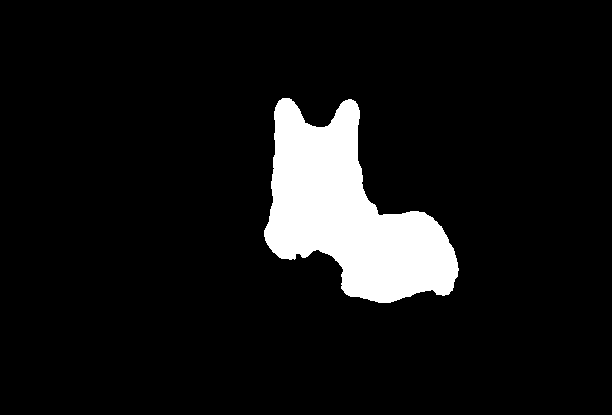

In [19]:
img_mask = Image.fromarray(mask,"L")
img_mask